# 1. Business Understanding
-------------------
In this notebook we will analyze participants identifying as a **'Data Scientist or Machine Learning specialist'** for data-driven findings about this role . The results of "Stack Overflow 2021 Developer survey" are used for this analysis.

We will analyze the following questions:

- How to enter the field as a DS/ML?
- Are DS/ ML roles still popular in small companies?
- Which programming languages and cloud platforms are DS / ML specialists using most commonly nowadays?
- How are 

# 2. General Data Understanding
-------------------
Before conducting analysis, we first need to understand the size and structure of our dataset and define cleaning steps.

### Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import html2text
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
pd.options.display.max_colwidth = 80

### Define helper functions

In [3]:
def col_description(df, col_names):
    """Print question description and id for specified column name from schema dataframe
    
    Keyword arguments:
        df -- pandas dataframe of Stack Overflow schema
        col_name (list) --  A list of column in schema dataframe
    """
    for col_name in col_names:
        try:
            desc = df[df['qname'] == col_name]['question'].values[0]
            desc = html2text.html2text(desc).rstrip('\n')
            qid = df[df['qname'] == col_name]['qid'].values[0]
            print(f"Question Name: {col_name}", "->", "Question ID: ", f"{qid}")
            print(f"\nDescription: {desc}")
        except Exception:
            print(f"Question '{col_name}' doesn't exist in the schema")
        print('-'* 100)
        
def check_null(df):
    """Check number of null records and percentage of each column in survey dataframe
    
    Keyword arguments:
        df -- Pandas dataframe
    Return
        Dataframe with null information
    """
    # Check null values by column
    null_df = df.isnull().sum().reset_index()
    null_df.columns = ['column', 'null_count']
    # Get null percentage
    null_df['null_perc'] = null_df['null_count']/survey.shape[0]
    # Sort results in descending order
    null_df = null_df.sort_values(by='null_perc', ascending=False)
    return null_df

def ma_distinct_values(df, column):
    """Print out distinct values of multiple choice questions. If the result is nan value, the value is 'No Answer'.
    
    Keyword arguments:
        df -- Pandas dataframe
        column (str) -- Name of column to be assessed
    """
    results = df[column]
    distinct_values = set()
    for result in results:
        if str(result)=='nan':
            values = ['No Answer']
        else:
            values = result.split(';')
        for value in values:
            distinct_values.add(value)
    # Convert to list
    distinct_values = list(distinct_values)
    print(distinct_values)
    
def sa_values_percentage(df, column, top=0, title='', color='pastel', plot=True):
    '''Calculate and visualize percentage of values of SINGLE ANSWER column. By default, result displays all values.
    
    Keyword arguments:
        df -- Pandas dataframe
        column (str) -- Name of column to be assessed
        top (int) -- The number of results to be displayed. By default, set to 0
        title (str) -- Plot title
        color (str) -- palette color for visualization
        plot (boolean) - providing whether or not you want a plot. If False, the function returns a cleaned dataframe.
    '''
    df_perc = df[column].value_counts(normalize=True)*100
    # By default, show all values
    if top == 0:
        pass
    else:
        df_perc = df_perc.iloc[:top]
    
    # If plot=True, visualize the results without returning the dataframe
    if plot:
        # Visualize
        plt.figure(figsize=(12, 8))
        sns.barplot(x=df_perc.values, y=df_perc.index, palette=color)
        plt.xlabel("Percentage")
        plt.tight_layout()
        if title == '':
            plt.title(column)
        else:
            plt.title(title)
        plt.show()
    else:
        return df_perc
        
def ma_values_percentage(df, column, top=0, title='', sep=';', color='pastel', plot=True):
    '''Calculate and visualize percentage of values of MULTIPLE ANSWER column. By default, result displays all values.
    
    Keyword arguments:
        df -- Pandas dataframe
        column (str) -- Name of column to be assessed
        top (int) -- The number of results to be displayed. By default, set to 0.
        sep (str) -- string separator pattern
        color (str) -- palette color for visualization
        plot (boolean) - providing whether or not you want a plot. If False, the function returns a cleaned dataframe.
    '''
    # Create a dummy dataframe
    dummy = df[column].str.get_dummies(sep=';')
    # Get percentage and sort values
    df_perc = dummy.sum()/df.shape[0]*100
    df_perc = df_perc.sort_values(ascending=False)
    # By default, show all values
    if top == 0:
        pass
    else:
        df_perc = df_perc.iloc[:top]
    
    # If plot=True, visualize the results without returning the dataframe
    if plot:
        # Visualize
        plt.figure(figsize=(12, 8))
        sns.barplot(x=df_perc.values, y=df_perc.index, palette=color)
        plt.xlabel("Percentage")
        plt.tight_layout()
        if title == '':
            plt.title(column)
        else:
            plt.title(title)
        plt.show()
    else:
        return df_perc
    
def compare_groups(column, group1, group1_label, group2, group2_label):
    '''Return a combined dataframe that shows differences in percentage between 2 groups
    
    Keyword arguments:
        column (str) -- field name used for comparison
        group1 (df) --  value percentage dataframe of the first group
        group1_label (str) -- label used for the first group
        group2 (df) -- value percentage dataframe of the second group
        group2_label (str) -- label used for the second group
    '''
    group1.columns = [column, group1_label]
    group2.columns = [column, group2_label]
    # Differences
    compare = pd.merge(group1, group2, on=column, how='left')
    compare['Diff'] = compare[group1_label] - compare[group2_label]
    compare = compare.style.bar(subset=['Diff'], align='mid', color=['#d65f5f', '#5fba7d'])
    return compare

def summarize_org_size(df):
    '''Return a dataframe that shows summary about organization size in a defined order.
    
    Keyword arguments:
        df -- a dataframe that has column 'OrgSize'
    '''
    org_size_dict = {
        'Just me - I am a freelancer, sole proprietor, etc.': 0,
        '2 to 9 employees': 0,
        '10 to 19 employees': 0,
        '20 to 99 employees': 0,
        '100 to 499 employees': 0,
        '500 to 999 employees': 0,
        '1,000 to 4,999 employees': 0,
        '5,000 to 9,999 employees': 0,
        '10,000 or more employees': 0,
        'I don’t know': 0
        }
    
    org_size = df['OrgSize'].value_counts()
    # If matched, then update the number
    for index, value in org_size.iteritems():
        if index in org_size_dict.keys():
            org_size_dict[index] = value
    # Convert to dataframe
    org_size_df = pd.DataFrame.from_dict(org_size_dict, orient='index').reset_index()
    org_size_df.columns = ['OrgSize', 'count']
    org_size_df['percentage'] = org_size_df['count']/org_size_df['count'].sum()*100
    return org_size_df

def ds_org_size(df):
    '''Return a dataframe that shows percentage of DS/AI Specialists for each Organization Size in a defined order.
    
    Keyword arguments:
        df -- a dataframe that has column 'OrgSize'
    '''
    org_size_dict =  {
        '2 to 9 employees': 0,
        '10 to 19 employees': 0,
        '20 to 99 employees': 0,
        '100 to 499 employees': 0,
        '500 to 999 employees': 0,
        '1,000 to 4,999 employees': 0,
        '5,000 to 9,999 employees': 0,
        '10,000 or more employees': 0
        }
    
    # If match, update the dict
    for value in df['OrgSize'].unique():
        if str(value) in ["nan", "I don’t know", "Just me - I am a freelancer, sole proprietor, etc."]:
            continue
        else:
            sub_df = df[df['OrgSize']==value]
            dev_perc = ma_values_percentage(sub_df, 'DevType', plot=False)
            ds_perc = dev_perc[dev_perc.index=='Data scientist or machine learning specialist'].values[0]
            if value in org_size_dict.keys():
                org_size_dict[value] = ds_perc
    # Convert to dataframe
    ds_by_orgsize = pd.DataFrame.from_dict(org_size_dict, orient='index').reset_index()
    ds_by_orgsize.columns = ['OrgSize', 'DS/ML Percentage']
    return ds_by_orgsize

def get_association_rules(df, column, sep=';', support_count=500, metric='lift', min_threshold=5):
    # Split a Multiple-answered column into many columns
    split_df = df[column].str.split(pat=';', expand=True)
    # Append results
    records = []
    for i in range(0, split_df.shape[0]):
        records.append([str(split_df.values[i, j]) for j in range(0, split_df.shape[1]) if str(split_df.values[i, j]) != 'None'])
    # TransactionEncoder
    te = TransactionEncoder()
    te_ary = te.fit(records).transform(records)
    te_df = pd.DataFrame(te_ary, columns=te.columns_)
    # Define min support
    min_support = support_count/len(te_df)
    # Create frequent itemsets
    frequent_itemsets = apriori(te_df, min_support=min_support, use_colnames=True) 
    # Get rules
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    rules = rules.sort_values(by=metric, ascending=False)
    return rules

### Load dataset

In [4]:
survey = pd.read_csv('data/survey_results_public.csv')
survey_schema = pd.read_csv('data/survey_results_schema.csv')

### Get description of interested columns

In [5]:
col_of_interest = ['Age1stCode', 'LearnCode', 'DevType', 'OrgSize', 'Language', 'Platform']

In [6]:
col_description(survey_schema, col_of_interest)

Question Name: Age1stCode -> Question ID:  QID149

Description: At what age did you write your first line of code or program? (e.g., webpage,
Hello World, Scratch project)
----------------------------------------------------------------------------------------------------
Question Name: LearnCode -> Question ID:  QID276

Description: How did you learn to code? Select all that apply.
----------------------------------------------------------------------------------------------------
Question Name: DevType -> Question ID:  QID31

Description: Which of the following describes your current job? Please select all that
apply.
----------------------------------------------------------------------------------------------------
Question Name: OrgSize -> Question ID:  QID29

Description: Approximately how many people are employed by the company or organization you
currently work for?
----------------------------------------------------------------------------------------------------
Question Nam

### Quick glance of dataset

In [7]:
# General info of dataset
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83439 entries, 0 to 83438
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ResponseId                    83439 non-null  int64  
 1   MainBranch                    83439 non-null  object 
 2   Employment                    83323 non-null  object 
 3   Country                       83439 non-null  object 
 4   US_State                      14920 non-null  object 
 5   UK_Country                    4418 non-null   object 
 6   EdLevel                       83126 non-null  object 
 7   Age1stCode                    83243 non-null  object 
 8   LearnCode                     82963 non-null  object 
 9   YearsCode                     81641 non-null  object 
 10  YearsCodePro                  61216 non-null  object 
 11  DevType                       66484 non-null  object 
 12  OrgSize                       60726 non-null  object 
 13  C

In [8]:
# Check several first rows
survey.head()

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-employed",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, German Realschule or Gymnasium,...",18 - 24 years,"Coding Bootcamp;Other online resources (ex: videos, blogs, etc)",NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc);School",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write code sometimes as part of my work","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc);Online Forum",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-employed",United Kingdom of Great Britain and Northern Ireland,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN


In [9]:
# Check several last rows
survey.tail()

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
83434,83435,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc);School;Online Forum",6,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a concentration and/or memory disorder (e.g. ADHD),Appropriate in length,Easy,160500.0
83435,83436,I am a developer by profession,"Independent contractor, freelancer, or self-employed",Benin,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc);School;Online Forum;Online C...",4,...,18-24 years old,Man,No,Straight / Heterosexual,Black or of African descent,None of the above,None of the above,Appropriate in length,Easy,3960.0
83436,83437,I am a developer by profession,Employed full-time,United States of America,New Jersey,NaN,"Secondary school (e.g. American high school, German Realschule or Gymnasium,...",11 - 17 years,School,10,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,90000.0
83437,83438,I am a developer by profession,Employed full-time,Canada,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,Online Courses or Certification;Books / Physical media,5,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,"I have a mood or emotional disorder (e.g. depression, bipolar disorder)",Appropriate in length,Neither easy nor difficult,816816.0
83438,83439,I am a developer by profession,Employed full-time,Brazil,NaN,NaN,"Professional degree (JD, MD, etc.)",11 - 17 years,School,14,...,18-24 years old,Man,No,Straight / Heterosexual,Hispanic or Latino/a/x,None of the above,None of the above,Appropriate in length,Easy,21168.0


### Check null values

In [10]:
# Check percentage of null values by column
null_df = check_null(survey)
# Check top 10 columns with highest null values
null_df.head(10)

,column,null_count,null_perc
5,UK_Country,79021,0.947051
4,US_State,68519,0.821187
25,MiscTechWantToWorkWith,45418,0.544326
21,PlatformWantToWorkWith,41820,0.501204
47,ConvertedCompYearly,36595,0.438584
24,MiscTechHaveWorkedWith,36384,0.436055
14,CompTotal,36256,0.434521
23,WebframeWantToWorkWith,31344,0.375652
20,PlatformHaveWorkedWith,31304,0.375172
15,CompFreq,31289,0.374993


# 3. Respondent Profiles
-------------------
To better understand the data, it's necessary to study backgrounds of persons whom are answering our survey

### Which countries do our respondents come from?

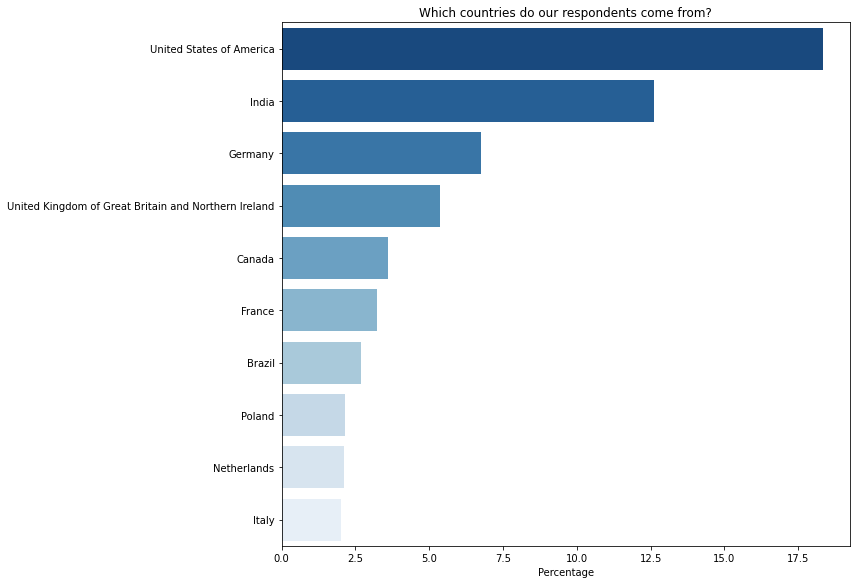

In [11]:
sa_values_percentage(survey, 'Country', top=10, 
                     title='Which countries do our respondents come from?',
                     color='Blues_r', plot=True)

**Comment**:
- A majority of respondents come home the U.S and India

### What are their current statuses?

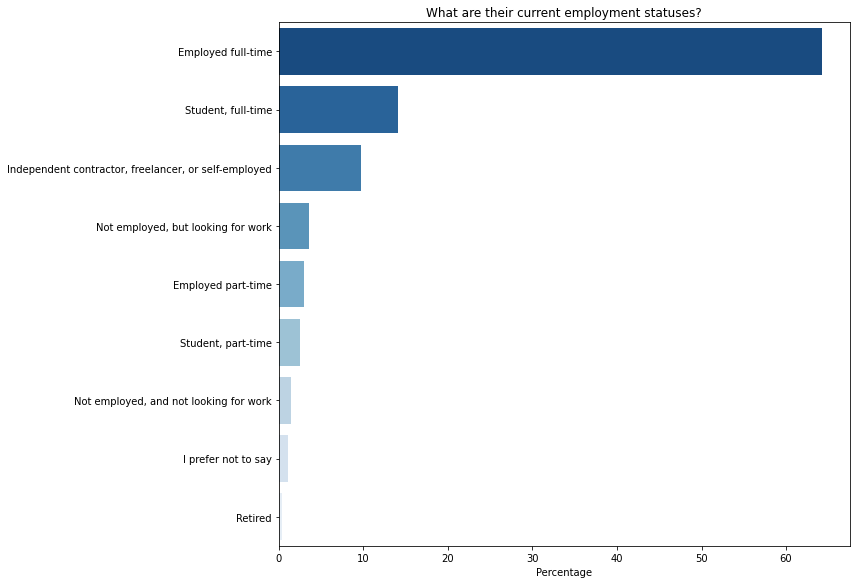

In [12]:
sa_values_percentage(survey, 'Employment',
                     title='What are their current employment statuses?', 
                     color='Blues_r', plot=True)

**Comment**
- Approximately 65% of respondents are full-time employees
- Then, followed by around 15% of students and 10% of freelance/self-employed persons.

### How about education level?

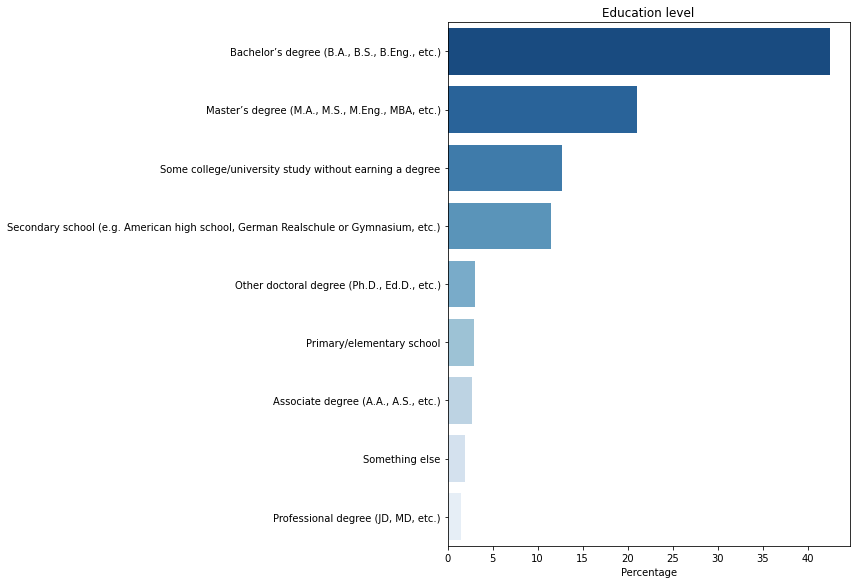

In [13]:
sa_values_percentage(survey, 'EdLevel',
                     title='Education level',
                     color='Blues_r', plot=True)

**Comment**
- Most possess Bachelor and Master Degree

### How many percent that Data Scientists and ML specialists occupy?

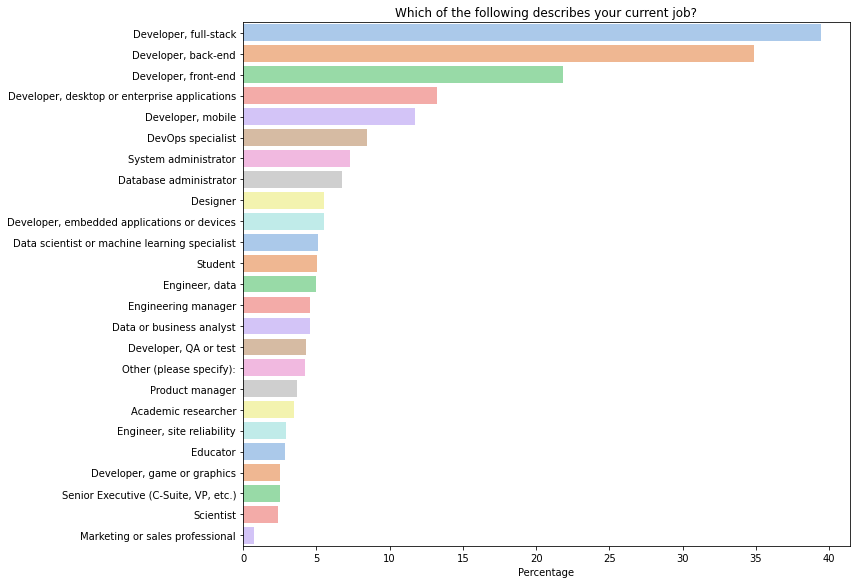

In [14]:
ma_values_percentage(survey, 'DevType', top=0,
                     title='Which of the following describes your current job?',
                     sep=';', plot=True)

**Comment**
- Around 5% percent of our respondents state their roles as Data scientists/ Machine Learning

# 4. Data preparation
-------------------
For this analysis, we're only interest in Data Scientist/ML Specialists.

In [15]:
# Check all unique Dev Types
ma_distinct_values(survey, 'DevType')

['Developer, game or graphics', 'Developer, full-stack', 'Student', 'Developer, front-end', 'Developer, embedded applications or devices', 'Data or business analyst', 'Engineering manager', 'Developer, QA or test', 'Product manager', 'Developer, back-end', 'Developer, desktop or enterprise applications', 'Senior Executive (C-Suite, VP, etc.)', 'DevOps specialist', 'Educator', 'Academic researcher', 'Other (please specify):', 'System administrator', 'Data scientist or machine learning specialist', 'No Answer', 'Engineer, data', 'Engineer, site reliability', 'Scientist', 'Developer, mobile', 'Database administrator', 'Designer', 'Marketing or sales professional']


In [16]:
# Create a flag column to separate Data scientists and Machine Learning specialists
survey['Flag_DSML'] = survey['DevType'].apply(lambda x: 'Data scientist or machine learning specialist' in str(x))

In [17]:
ds = survey[survey['Flag_DSML'] == True]
non_ds = survey[survey['Flag_DSML'] == False]

In [18]:
# The number of DS/ML Specialists
len(ds)

4273

In [19]:
# The number of other Dev Type
len(non_ds)

79166

# 5. Data Analysis


### Question 1: Are the demands for Data Scientists/ Machine Learning Specialists higher in big companies? 

In [20]:
# Get overview of company size in our dataset
org_size_df = summarize_org_size(survey)
org_size_df

,OrgSize,count,percentage
0,"Just me - I am a freelancer, sole proprietor, etc.",4033,6.641307
1,2 to 9 employees,6551,10.787801
2,10 to 19 employees,5404,8.898989
3,20 to 99 employees,12507,20.595791
4,100 to 499 employees,10506,17.300662
5,500 to 999 employees,3789,6.239502
6,"1,000 to 4,999 employees",6287,10.353061
7,"5,000 to 9,999 employees",2279,3.752923
8,"10,000 or more employees",8016,13.200277
9,I don’t know,1354,2.229687


In [21]:
# For each company size, get the percentage of respondents who describes their role as DS/ML specialists
ds_by_orgsize = ds_org_size(survey)
ds_by_orgsize

,OrgSize,DS/ML Percentage
0,2 to 9 employees,6.166997
1,10 to 19 employees,5.625463
2,20 to 99 employees,5.636843
3,100 to 499 employees,5.358843
4,500 to 999 employees,6.228556
5,"1,000 to 4,999 employees",7.364403
6,"5,000 to 9,999 employees",8.161474
7,"10,000 or more employees",8.495509


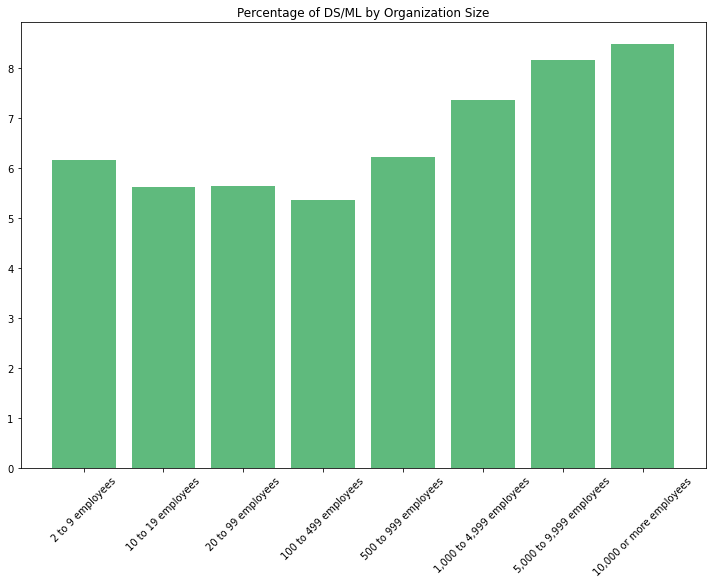

In [22]:
# Visualize results
plt.figure(figsize=(10, 8))
plt.bar(data=ds_by_orgsize, x='OrgSize', height='DS/ML Percentage', color='#5fba7d')
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("Percentage of DS/ML by Organization Size")
plt.show()

### Question 2: How to enter the field as a DS/ML?

In [23]:
# DS Education
ds_education = sa_values_percentage(ds, 'EdLevel', plot=False)
ds_education = ds_education.reset_index()
# Non-DS Education
non_ds_education = sa_values_percentage(non_ds, 'EdLevel', plot=False)
non_ds_education = non_ds_education.reset_index()

In [24]:
education = compare_groups('EdLevel', ds_education, 'DS/ML', non_ds_education, 'Other Roles')
education

,EdLevel,DS/ML,Other Roles,Diff
0,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",40.749415,20.001015,20.748400
1,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",30.819672,43.168560,-12.348888
2,"Other doctoral degree (Ph.D., Ed.D., etc.)",16.627635,2.354925,14.272709
3,Some college/university study without earning a degree,5.199063,13.146749,-7.947685
4,"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",2.505855,11.954702,-9.448847
5,"Professional degree (JD, MD, etc.)",1.662763,1.502739,0.160024
6,"Associate degree (A.A., A.S., etc.)",0.983607,2.775946,-1.792339
7,Primary/elementary school,0.725995,3.104393,-2.378398
8,Something else,0.725995,1.990971,-1.264976


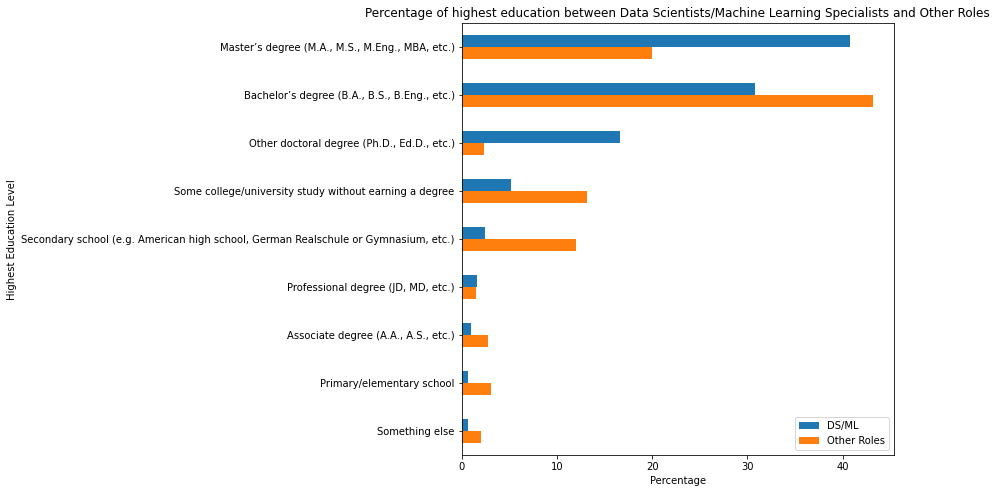

In [166]:
# Get dataframe
education_df = education.data[['EdLevel', 'DS/ML', 'Other Roles']]
education_df.set_index('EdLevel', inplace=True)

# Visualize results
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

axes = education_df.plot.barh()
set_size(6,6, ax=axes)
plt.title("Percentage of highest education between Data Scientists/Machine Learning Specialists and Other Roles")
plt.ylabel("Highest Education Level")
plt.xlabel("Percentage")
plt.gca().invert_yaxis()
plt.show()

In [25]:
# Check all unique LearnCode
ma_distinct_values(survey, 'LearnCode')

['Online Forum', 'Friend or family member', 'Other online resources (ex: videos, blogs, etc)', 'Other (please specify):', 'Colleague', 'Online Courses or Certification', 'No Answer', 'Coding Bootcamp', 'School', 'Books / Physical media']


In [26]:
# DS Learn Code
ds_learncode = ma_values_percentage(ds, 'LearnCode', plot=False)
ds_learncode = ds_learncode.reset_index()
# Non DS Learn Code
non_ds_learncode = ma_values_percentage(non_ds, 'LearnCode', plot=False)
non_ds_learncode = non_ds_learncode.reset_index()

In [27]:
learncode = compare_groups('LearnCode', ds_learncode, 'DS/ML', non_ds_learncode, 'Other Roles')
learncode

,LearnCode,DS/ML,Other Roles,Diff
0,School,59.255792,52.964657,6.291136
1,Books / Physical media,56.143225,50.972640,5.170585
2,"Other online resources (ex: videos, blogs, etc)",55.838989,59.376500,-3.537511
3,Online Courses or Certification,43.365317,39.989389,3.375928
4,Online Forum,32.880880,31.356896,1.523984
5,Friend or family member,20.524222,18.044362,2.479859
6,Colleague,20.032764,16.887300,3.145464
7,Coding Bootcamp,10.461034,10.167244,0.293791
8,Other (please specify):,9.992979,8.206806,1.786173


### Question 3: Which other roles are closely associated to Data Scientists/Machine Learning Specialists?

In [28]:
# Get rules
rules = get_association_rules(survey, 'DevType')

In [29]:
# Filter 
rules['flag_DS'] = rules['antecedents'].apply(lambda x: True if "['Data scientist or machine learning specialist']" == str(list(x)) else False)
rules = rules[rules['flag_DS']==True]
rules['consequents'] = rules['consequents'].apply(lambda x: '; '.join(list(x)))
rules = rules[['antecedents', 'consequents', 'lift']]

In [66]:
rules

,antecedents,consequents,lift
14,(Data scientist or machine learning specialist),Scientist,7.878648
0,(Data scientist or machine learning specialist),Academic researcher,6.136297
6,(Data scientist or machine learning specialist),Data or business analyst,5.731431
30,(Data scientist or machine learning specialist),"Developer, back-end; Data or business analyst",5.261277
12,(Data scientist or machine learning specialist),"Engineer, data",5.204402


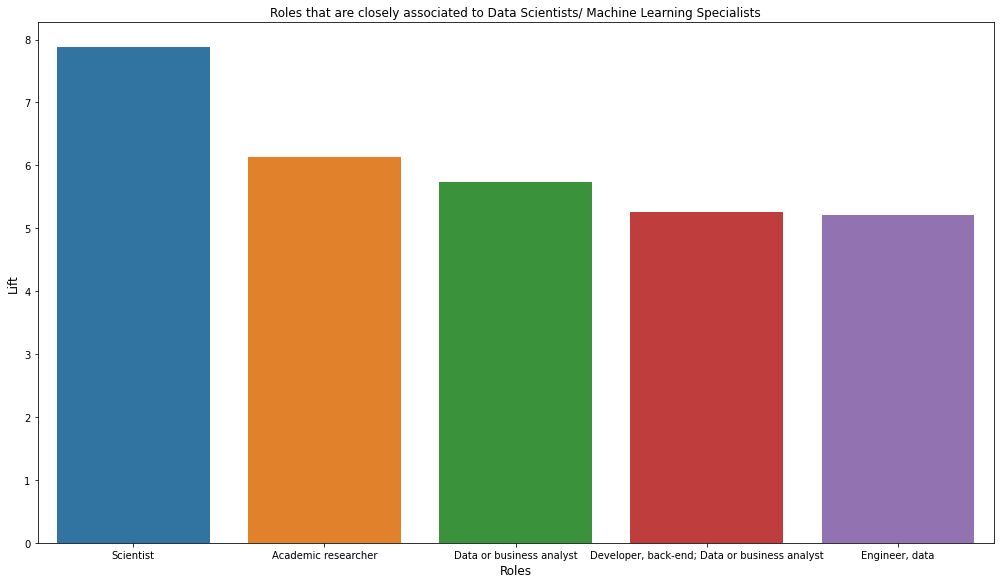

In [97]:
# Visualize
plt.figure(figsize=(14, 8))
sns.barplot(data=rules, x='consequents', y='lift')
plt.xticks(fontsize=10)
plt.xlabel('Roles', fontsize=12)
plt.ylabel('Lift', fontsize=12)
plt.tight_layout()
plt.title("Roles that are closely associated to Data Scientists/ Machine Learning Specialists")
plt.show()

### Question 4: Which programming languages and libraries are DS / ML specialists using most commonly nowadays?

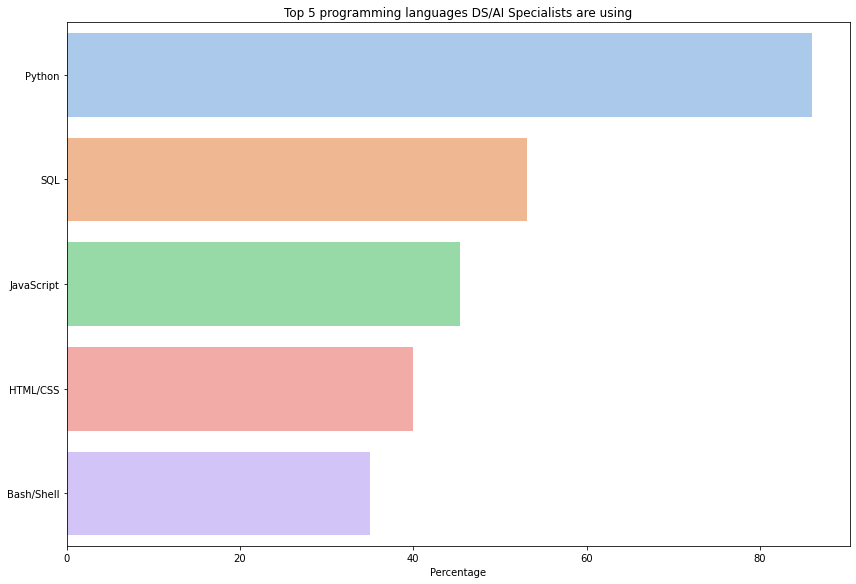

In [38]:
# DS Programming Language
ds_programming = ma_values_percentage(ds, 'LanguageHaveWorkedWith', top=5, 
                                      title='Top 5 programming languages DS/AI Specialists are using')

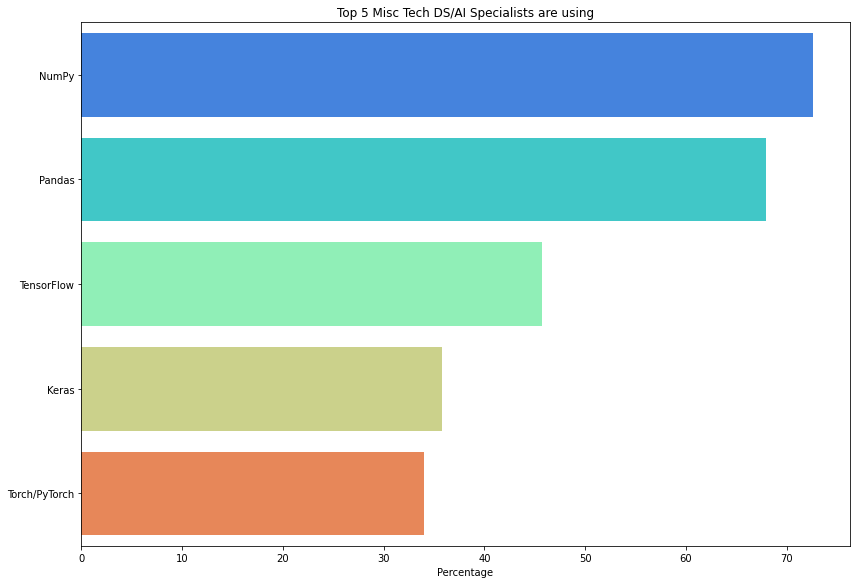

In [40]:
# DS Misc Tech
ds_mistech = ma_values_percentage(ds, 'MiscTechHaveWorkedWith', top=5, 
                                  title='Top 5 Misc Tech DS/AI Specialists are using',
                                  color='rainbow')